**필요한 패키지 설치**

In [ ]:
pip install konlpy

In [ ]:
pip install fasttext

In [ ]:
pip install jamo

In [ ]:
pip install tqdm

In [ ]:
pip install pyyaml h5py

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    # train, test로 나누기 위한 패키지
from konlpy.tag import *  # 한국어 처리를 위한 패키지
import re # 정규표현식 패키지

import fasttext
from tqdm import tqdm_notebook
from keras.layers import LSTM, Activation, Dropout, Dense, Input,Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import layers
from keras.callbacks import EarlyStopping
import keras
from keras.models import Sequential

In [8]:
data = pd.read_csv('/content/data.csv')
data.Sentence = data.Sentence.astype(str) # Sentence칼럼 값들을 str로 변환
data.head(6)

,Unnamed: 0,Sentence,label_word,label
0,0,홍진영 언니 연기 잘 해 얼굴두 이쁘구 노래두 잘 부르구 끼도 많음 나는 퍽,긍정,0
1,1,그동안 열심히 앞만 보면서 묵묵히 살아왔는데 건강이 많이 안 좋다고 하네 열심히 살...,부정,1
2,2,나를 떨리게 하나요 부터 완전 끌림 장범준 노래 멋져요,긍정,0
3,3,도움이 되었습니다 감사합니다,긍정,0
4,4,똥이 묻었노,욕설,2
5,5,저런 새 기들 땜에 얼마 전에 문 신충한테 쳐 맞은 택시 기사도 잘 쳐 맞았다는 소...,욕설,2


**train / test 분류** 

In [9]:
sentence_train, sentence_test, label_train, label_test = train_test_split(data['Sentence'], data['label'], test_size = 0.2, shuffle = False)    

**데이터프레임으로 만들기**

In [10]:
lis1 =[]
lis2 = []
lis3 =[]
lis4 = []

for i in sentence_train:
  lis1.append(i)

for i in label_train:
  lis2.append(i)

for i in sentence_test:
  lis3.append(i)

for i in label_test:
  lis4.append(i)

In [11]:
train_df = pd.DataFrame((zip(lis1, lis2)), columns = ['Sentence', 'label'])
test_df = pd.DataFrame((zip(lis3, lis4)), columns = ['Sentence', 'label'])

In [12]:
train_df

,Sentence,label
0,홍진영 언니 연기 잘 해 얼굴두 이쁘구 노래두 잘 부르구 끼도 많음 나는 퍽,0
1,그동안 열심히 앞만 보면서 묵묵히 살아왔는데 건강이 많이 안 좋다고 하네 열심히 살...,1
2,나를 떨리게 하나요 부터 완전 끌림 장범준 노래 멋져요,0
3,도움이 되었습니다 감사합니다,0
4,똥이 묻었노,2
...,...,...
19785,니가 민폐인걸 지금 알앗니,2
19786,웃고 간다 병신아,2
19787,아직도 건강이 나빠지는 게 걱정 돼서 영 양제를 챙겨 먹고 있어,1
19788,예쁘고 노래도 좋고 춤도 멋지고 구독 눌르고 갑니다 진짜로 노래 넘 좋당,0


In [13]:
test_df

,Sentence,label
0,이 지 지배 젖을 잘라 버리든지 해야지 미성년 자식 키우는 부모 입장에서 애 볼까 ...,2
1,대리 때문에 항상 당황 스러워 왜 꼭 새로 들어온 여 사원들에게만 관심이 많은지,1
2,평생 가족을 위해 희생 했는데 이제 남은건 여러가지 병들 뿐이야,1
3,지인이 이혼 해서 혼자 살다가 고독 사했대 갑자기 들은 거라 당황 스러워,1
4,아 이분 영상 몇번 봣 엇 는 뎅 이 영 상보고 바로 구독 눌러 드려용 멋지십니다,0
...,...,...
4943,활기찬 하루를 보내려고 해도 기운이 없어 힘들어,1
4944,요리를 하다가 칼에 손이 많이 베여서 병원에 갔는데 다행히 인대는 안 다쳤데 얼마나...,0
4945,아직 한국 여자랑 결혼 하는 등신이 있냐,2
4946,하다하다 데이트 폭력 범을 방송에 소환 하니,2





-------------------------------------------------------------------------------







**지표**

In [14]:
train_df['Sentence'].nunique(), train_df['label'].nunique()

(19161, 3)

In [15]:
train_df.drop_duplicates(subset=['Sentence'], inplace=True)

In [16]:
print('총 샘플의 수 :',len(train_df))

총 샘플의 수 : 19161


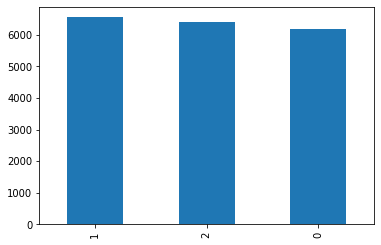

In [17]:
train_df['label'].value_counts().plot(kind = 'bar')

In [18]:
print(train_df.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   6195
1      1   6550
2      2   6416




---
**전처리 & 토큰화**

In [20]:
okt = Okt()

**train_df 전처리 & test_df 전처리**

In [21]:
# 특수문자, 이모티콘 제거
temp_list=[]

for i in train_df.Sentence:
  s = ' '.join(re.compile('[가-힣]+').findall(i))
  temp_list.append(s)

train_df.Sentence = temp_list

# 한글자 단어 제거 ex) 그, 너, 또...
temp_list=[]

for i in train_df.Sentence:
  li = []
  for index in range(len(i.split())):
    if len(i.split()[index]) > 1:
      li.append(i.split()[index])
  
  s = " ".join(li)
  temp_list.append(s)

train_df.Sentence = temp_list

In [22]:
def word_split(x):
  return len(x.split())

train_df['word_count'] = train_df['Sentence'].apply(word_split)
train_df = train_df[train_df.word_count>=5]

In [23]:
train_df

,Sentence,label,word_count
0,홍진영 언니 연기 얼굴두 이쁘구 노래두 부르구 끼도 많음 나는,0,10
1,그동안 열심히 앞만 보면서 묵묵히 살아왔는데 건강이 많이 좋다고 하네 열심히 살아온...,1,15
2,나를 떨리게 하나요 부터 완전 끌림 장범준 노래 멋져요,0,9
5,저런 기들 땜에 얼마 전에 신충한테 맞은 택시 기사도 맞았다는 소리가 나오는거다,2,12
6,모르지 떨군 고개 환한 조명이 어딜 비추는지 가사가 특히 좋더라구요 위로 받는 듯한...,0,19
...,...,...,...
19783,좌파 종북 정권의 민낮 영영꺼 지지 않는 유황 기름 솥에 떨어질것,2,11
19784,끼들이 어떻게 무너지고 남은 인생과 주변이 끝장 나는지 지켜본다 시발,2,10
19787,아직도 건강이 나빠지는 걱정 돼서 양제를 챙겨 먹고 있어,1,9
19788,예쁘고 노래도 좋고 춤도 멋지고 구독 눌르고 갑니다 진짜로 노래 좋당,0,11


In [24]:
train_df = train_df[train_df.word_count<=25]

In [ ]:
from jamo import h2j, j2hcj

temp_list = []
for i in train_df.Sentence:
  i = j2hcj(h2j(i)) + ' '
  temp_list.append(i)

train_df.Sentence = temp_list

In [26]:
train_df

,Sentence,label,word_count
0,ㅎㅗㅇㅈㅣㄴㅇㅕㅇ ㅇㅓㄴㄴㅣ ㅇㅕㄴㄱㅣ ㅇㅓㄹㄱㅜㄹㄷㅜ ㅇㅣㅃㅡㄱㅜ ㄴㅗㄹㅐㄷㅜ ㅂ...,0,10
1,ㄱㅡㄷㅗㅇㅇㅏㄴ ㅇㅕㄹㅅㅣㅁㅎㅣ ㅇㅏㅍㅁㅏㄴ ㅂㅗㅁㅕㄴㅅㅓ ㅁㅜㄱㅁㅜㄱㅎㅣ ㅅㅏㄹㅇ...,1,15
2,ㄴㅏㄹㅡㄹ ㄸㅓㄹㄹㅣㄱㅔ ㅎㅏㄴㅏㅇㅛ ㅂㅜㅌㅓ ㅇㅘㄴㅈㅓㄴ ㄲㅡㄹㄹㅣㅁ ㅈㅏㅇㅂㅓㅁ...,0,9
5,ㅈㅓㄹㅓㄴ ㄱㅣㄷㅡㄹ ㄸㅐㅁㅇㅔ ㅇㅓㄹㅁㅏ ㅈㅓㄴㅇㅔ ㅅㅣㄴㅊㅜㅇㅎㅏㄴㅌㅔ ㅁㅏㅈㅇ...,2,12
6,ㅁㅗㄹㅡㅈㅣ ㄸㅓㄹㄱㅜㄴ ㄱㅗㄱㅐ ㅎㅘㄴㅎㅏㄴ ㅈㅗㅁㅕㅇㅇㅣ ㅇㅓㄷㅣㄹ ㅂㅣㅊㅜㄴㅡ...,0,19
...,...,...,...
19783,ㅈㅘㅍㅏ ㅈㅗㅇㅂㅜㄱ ㅈㅓㅇㄱㅝㄴㅇㅢ ㅁㅣㄴㄴㅏㅈ ㅇㅕㅇㅇㅕㅇㄲㅓ ㅈㅣㅈㅣ ㅇㅏㄶㄴ...,2,11
19784,ㄲㅣㄷㅡㄹㅇㅣ ㅇㅓㄸㅓㅎㄱㅔ ㅁㅜㄴㅓㅈㅣㄱㅗ ㄴㅏㅁㅇㅡㄴ ㅇㅣㄴㅅㅐㅇㄱㅘ ㅈㅜㅂㅕㄴ...,2,10
19787,ㅇㅏㅈㅣㄱㄷㅗ ㄱㅓㄴㄱㅏㅇㅇㅣ ㄴㅏㅃㅏㅈㅣㄴㅡㄴ ㄱㅓㄱㅈㅓㅇ ㄷㅙㅅㅓ ㅇㅑㅇㅈㅔㄹㅡ...,1,9
19788,ㅇㅖㅃㅡㄱㅗ ㄴㅗㄹㅐㄷㅗ ㅈㅗㅎㄱㅗ ㅊㅜㅁㄷㅗ ㅁㅓㅅㅈㅣㄱㅗ ㄱㅜㄷㅗㄱ ㄴㅜㄹㄹㅡㄱ...,0,11


In [27]:
# 특수문자, 이모티콘 제거
temp_list=[]

for i in test_df.Sentence:
  s = ' '.join(re.compile('[가-힣]+').findall(i))
  temp_list.append(s)

test_df.Sentence = temp_list

# 한글자 단어 제거 ex) 그, 너, 또...
temp_list=[]

for i in test_df.Sentence:
  li = []
  for index in range(len(i.split())):
    if len(i.split()[index]) > 1:
      li.append(i.split()[index])
  
  s = " ".join(li)
  temp_list.append(s)

test_df.Sentence = temp_list

In [28]:
test_df['word_count'] = test_df['Sentence'].apply(word_split)
test_df = test_df[test_df.word_count>=5]

In [29]:
test_df = test_df[test_df.word_count<=25]

In [30]:
temp_list = []
for i in test_df.Sentence:
  i = j2hcj(h2j(i)) + ' '
  temp_list.append(i)

test_df.Sentence = temp_list

In [31]:
test_df

,Sentence,label,word_count
0,ㅈㅣㅂㅐ ㅈㅓㅈㅇㅡㄹ ㅈㅏㄹㄹㅏ ㅂㅓㄹㅣㄷㅡㄴㅈㅣ ㅎㅐㅇㅑㅈㅣ ㅁㅣㅅㅓㅇㄴㅕㄴ ㅈㅏ...,2,18
1,ㄷㅐㄹㅣ ㄸㅐㅁㅜㄴㅇㅔ ㅎㅏㅇㅅㅏㅇ ㄷㅏㅇㅎㅘㅇ ㅅㅡㄹㅓㅇㅝ ㅅㅐㄹㅗ ㄷㅡㄹㅇㅓㅇㅗ...,1,10
2,ㅍㅕㅇㅅㅐㅇ ㄱㅏㅈㅗㄱㅇㅡㄹ ㅇㅟㅎㅐ ㅎㅢㅅㅐㅇ ㅎㅐㅆㄴㅡㄴㄷㅔ ㅇㅣㅈㅔ ㄴㅏㅁㅇㅡ...,1,10
3,ㅈㅣㅇㅣㄴㅇㅣ ㅇㅣㅎㅗㄴ ㅎㅐㅅㅓ ㅎㅗㄴㅈㅏ ㅅㅏㄹㄷㅏㄱㅏ ㄱㅗㄷㅗㄱ ㅅㅏㅎㅐㅆㄷㅐ...,1,12
4,ㅇㅣㅂㅜㄴ ㅇㅕㅇㅅㅏㅇ ㅁㅕㅊㅂㅓㄴ ㅅㅏㅇㅂㅗㄱㅗ ㅂㅏㄹㅗ ㄱㅜㄷㅗㄱ ㄴㅜㄹㄹㅓ ㄷ...,0,9
...,...,...,...
4943,ㅎㅘㄹㄱㅣㅊㅏㄴ ㅎㅏㄹㅜㄹㅡㄹ ㅂㅗㄴㅐㄹㅕㄱㅗ ㅎㅐㄷㅗ ㄱㅣㅇㅜㄴㅇㅣ ㅇㅓㅄㅇㅓ ㅎ...,1,7
4944,ㅇㅛㄹㅣㄹㅡㄹ ㅎㅏㄷㅏㄱㅏ ㅋㅏㄹㅇㅔ ㅅㅗㄴㅇㅣ ㅁㅏㄶㅇㅣ ㅂㅔㅇㅕㅅㅓ ㅂㅕㅇㅇㅝㄴ...,0,13
4945,ㅇㅏㅈㅣㄱ ㅎㅏㄴㄱㅜㄱ ㅇㅕㅈㅏㄹㅏㅇ ㄱㅕㄹㅎㅗㄴ ㅎㅏㄴㅡㄴ ㄷㅡㅇㅅㅣㄴㅇㅣ ㅇㅣㅆㄴㅑ,2,7
4946,ㅎㅏㄷㅏㅎㅏㄷㅏ ㄷㅔㅇㅣㅌㅡ ㅍㅗㄱㄹㅕㄱ ㅂㅓㅁㅇㅡㄹ ㅂㅏㅇㅅㅗㅇㅇㅔ ㅅㅗㅎㅘㄴ ㅎ...,2,7


**fasttext이용해 단어를 벡터로 변환**

In [32]:
train_df.Sentence.to_csv('data_train.txt')
test_df.Sentence.to_csv('data_test.txt')

In [33]:
ft_model = fasttext.train_unsupervised(input='/content/data_train.txt', model = 'skipgram', lr = 0.05, dim = 100, ws = 5, epoch = 50, minn = 1, wordNgrams = 5)
# model = skipgram
# lr = learning rate
# dim = dimension
# ws = window size
# minn = 최소 character ngram
# wordNgrams = 	max length of word ngram

In [34]:
ft_model.save_model('ft_model.bin')

In [35]:
words = ft_model.get_words()
print(words)

['</s>', 'ㅎㅏㄴㅡㄴ', 'ㅎㅐㅅㅓ', 'ㄱㅏㅌㅇㅏ', 'ㄴㅐㄱㅏ', 'ㅎㅐㅆㄴㅡㄴㄷㅔ', 'ㄴㅏㄹㅡㄹ', 'ㅁㅏㄶㅇㅣ', 'ㅎㅐㅆㅇㅓ', 'ㅊㅣㄴㄱㅜㄱㅏ', 'ㅈㅗㅎㅇㅡㄴ', 'ㅎㅏㄱㅗ', 'ㅅㅐㅇㄱㅏㄱ', 'ㄸㅐㅁㅜㄴㅇㅔ', 'ㅂㅗㄱㅗ', 'ㄱㅏㅁㅅㅏㅎㅏㅂㄴㅣㄷㅏ', 'ㅎㅏㅈㅣ', 'ㅇㅣㅆㄴㅡㄴ', 'ㅅㅡㄹㅍㅓ', 'ㄷㅏㅇㅎㅘㅇ', 'ㅎㅘㄱㅏ', 'ㅅㅡㄹㅓㅇㅝ', 'ㅎㅏㄴㅡㄴㄷㅔ', 'ㄴㅗㄹㅐ', 'ㅇㅣㅆㅇㅓ', 'ㅈㅗㅎㅇㅏㅇㅛ', 'ㅎㅏㅁㅕㄴ', 'ㄱㅏㅌㅇㅡㄴ', 'ㅈㅗㅎㅇㅏ', 'ㅅㅏㄹㅏㅇ', 'ㅇㅏㄶㅇㅏ', 'ㅎㅏㅂㄴㅣㄷㅏ', 'ㅇㅣㅆㄴㅡㄴㄷㅔ', 'ㅇㅓㅄㅇㅓ', 'ㄱㅏㅌㅇㅏㅅㅓ', 'ㅇㅜㄹㅣ', 'ㅇㅣㄹㅓㅎㄱㅔ', 'ㅈㅗㄴㄴㅏ', 'ㅇㅓㅄㄴㅡㄴ', 'ㅇㅣㄹㅓㄴ', 'ㅇㅓㄸㅓㅎㄱㅔ', 'ㄷㅏㄹㅡㄴ', 'ㄴㅏㄴㅡㄴ', 'ㄷㅡㄹㅇㅓ', 'ㅁㅏㅇㅡㅁㅇㅣ', 'ㅂㅜㄹㅇㅏㄴㅎㅐ', 'ㄱㅖㅅㅗㄱ', 'ㅎㅐㅇㅑ', 'ㅅㅏㄹㅏㅁㅇㅣ', 'ㅁㅏㄹㅇㅡㄹ', 'ㅈㅏㄲㅜ', 'ㄱㅣㅂㅜㄴㅇㅣ', 'ㄱㅣㅃㅓ', 'ㅂㅗㄴㅣ', 'ㅎㅏㅇㅅㅏㅇ', 'ㄱㅏㅂㅈㅏㄱㅣ', 'ㅂㅗㅁㅕㄴ', 'ㄱㅓㄱㅈㅓㅇ', 'ㅇㅣㅂㄴㅣㄷㅏ', 'ㄱㅏㅌㅇㅣ', 'ㅅㅗㄱㅅㅏㅇㅎㅐ', 'ㄴㅏㄷㅗ', 'ㅇㅣㅆㅇㅓㅅㅓ', 'ㄴㅏㅎㅏㄴㅌㅔ', 'ㅎㅏㄴㅔ', 'ㅎㅣㅁㄷㅡㄹㅇㅓ', 'ㅇㅓㅄㅇㅓㅅㅓ', 'ㅈㅗㅎㄷㅏ', 'ㅎㅏㄱㅔ', 'ㅎㅐㄷㅗ', 'ㅁㅜㅅㅡㄴ', 'ㅈㅗㄴㄱㅕㅇ', 'ㅇㅕㅇㅅㅏㅇ', 'ㄱㅜㄷㅗㄱ', 'ㅅㅏㄹㅏㅁ', 'ㅎㅗㄴㅈㅏ', 'ㅂㅏㄷㅇㅏㅆㅇㅓ', 'ㅈㅗㅎㅇㅏㅎㅏㄴㅡㄴ', 'ㅇㅓㅄㅇㅣ', 'ㄷㅚㄴㅡㄴ', 'ㅇㅛㅈㅡㅁ', 'ㅇㅕㅈㅏ', 'ㅇㅣㅈㅔ', 'ㅇㅣㄹㅇㅡㄹ', 'ㅁㅗㄹㅡㄱㅔㅆㅇㅓ', 'ㅇㅣㄹㅇㅣ', 'ㄱㅣㅂㅜ', 'ㅊㅣㄴㄱㅜㄷㅡㄹㅇㅣ', 'ㅇㅕㄹㅅㅣㅁㅎㅣ', 'ㅇㅏㄶㅇㅏㅅㅓ', 'ㅅㅐㄲㅣ', 'ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅣ', 'ㅅㅐㄲㅣㄷㅡㄹ', 'ㄴㅏㅇㅔㄱㅔ', 'ㅎㅏㄴㅏ', 'ㅇㅓㄹㅁㅏㄴㅏ', 'ㅁㅏㄶㅇㅡㄴ', 'ㄱㅓㅅㄷㅗ', 'ㅇㅏㄴㅐㄱㅏ', 'ㅎㅏㅁㄲㅔ', 'ㄱㅕㄹㅎㅗㄴ', 'ㅅㅣㅍㅇㅓ', '

In [36]:
# fasttext api설명 https://nodoudt.tistory.com/55
ft_model.get_sentence_vector('ㄷㅐㅎㅏㄱ')

array([ 0.01324056,  0.00580734, -0.08664867, -0.17019963,  0.16887508,
       -0.07869152, -0.03167704,  0.01322292,  0.1361508 ,  0.2070557 ,
       -0.10869481,  0.03515778, -0.09198602, -0.03679711, -0.0209198 ,
        0.15279567, -0.1131694 ,  0.13841309, -0.01095998, -0.0136619 ,
       -0.02808256,  0.08644884,  0.05041374, -0.20632719,  0.00311497,
       -0.05439674, -0.08410746, -0.03875487, -0.02194262,  0.07261845,
        0.0354588 ,  0.14057828,  0.02704811, -0.15029638, -0.02713206,
       -0.00334003, -0.03311166,  0.07718796, -0.16876212,  0.18929045,
        0.11011752, -0.11711889,  0.22883749,  0.06884044, -0.11692058,
       -0.15137048, -0.08184246,  0.02491824, -0.05123064, -0.07143852,
        0.18881813, -0.05072917,  0.04362598, -0.00250375, -0.01656044,
       -0.00626639, -0.1175679 ,  0.13039884, -0.00133363, -0.09688377,
        0.07041819,  0.13640255,  0.02406656,  0.10992698,  0.01849504,
       -0.10002455, -0.10025406, -0.10220017, -0.00636648,  0.15

**임베딩**

In [37]:
from tqdm.notebook import tqdm

In [38]:
train_vec = []
sentence_number = 25    # 25개 초과 단어는 제거해서 25로 설정

for sen in tqdm(train_df.Sentence.values):
  word_list_vec = []
  sen_split = sen.split()
  for w_index in range(sentence_number):
    if w_index < len(sen_split):
      word_list_vec.append(ft_model[sen_split[w_index]])
    else:
      word_list_vec.append(np.array([0]*100))
  word_list_vec = np.array(word_list_vec)
  train_vec.append(word_list_vec)

train_vec = np.array(train_vec)
train_vec.shape

  0%|          | 0/14282 [00:00<?, ?it/s]

(14282, 25, 100)

In [40]:
test_vec = []
sentence_number = 25

for sen in tqdm(test_df.Sentence.values):
  word_list_vec = []
  sen_split = sen.split()
  for w_index in range(sentence_number):
    if w_index < len(sen_split):
      word_list_vec.append(ft_model[sen_split[w_index]])
    else:
      word_list_vec.append(np.array([0]*100))
  word_list_vec = np.array(word_list_vec)
  test_vec.append(word_list_vec)

test_vec = np.array(test_vec)

  0%|          | 0/3600 [00:00<?, ?it/s]

**Y(label) get_dummies(원핫인코딩)**

In [41]:
y_train = pd.get_dummies(train_df['label']).values

In [43]:
y_test = pd.get_dummies(test_df['label']).values

In [44]:
X_train = train_vec

In [45]:
X_test = test_vec

In [47]:
import tensorflow as tf

**모델링**

In [48]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(25, 100)))
model.add(Dense(3, activation='sigmoid'))
model.compile( optimizer = tf.keras.optimizers.RMSprop( learning_rate = 0.001 ), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 4,473
Trainable params: 4,473
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train, y_train, epochs = 30, callbacks=tf.keras.callbacks.EarlyStopping('val_loss',patience=5),validation_split=0.2)

Epoch 1/30
358/358 [==============================] - 8s 15ms/step - loss: 0.7377 - accuracy: 0.6551 - val_loss: 0.6486 - val_accuracy: 0.6867
Epoch 2/30
358/358 [==============================] - 5s 13ms/step - loss: 0.5298 - accuracy: 0.7910 - val_loss: 0.4263 - val_accuracy: 0.8547
Epoch 3/30
358/358 [==============================] - 5s 13ms/step - loss: 0.3895 - accuracy: 0.8675 - val_loss: 0.4060 - val_accuracy: 0.8551
Epoch 4/30
358/358 [==============================] - 5s 13ms/step - loss: 0.3335 - accuracy: 0.8902 - val_loss: 0.3213 - val_accuracy: 0.8866
Epoch 5/30
358/358 [==============================] - 5s 13ms/step - loss: 0.2972 - accuracy: 0.9007 - val_loss: 0.3555 - val_accuracy: 0.8736
Epoch 6/30
358/358 [==============================] - 5s 13ms/step - loss: 0.2721 - accuracy: 0.9097 - val_loss: 0.2841 - val_accuracy: 0.8978
Epoch 7/30
358/358 [==============================] - 5s 13ms/step - loss: 0.2537 - accuracy: 0.9143 - val_loss: 0.3313 - val_accuracy: 0.8880

In [50]:
loss, acc = model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

113/113 [==============================] - 0s 4ms/step - loss: 0.2648 - accuracy: 0.9128
Test loss: 0.2648204267024994
Test accuracy: 0.9127777814865112


In [51]:
model.save('Kor_NLP_LSTM.h5')

**모델 테스트**

In [53]:
def model_test(s, fasttext_model, lstm_model):
  test_word = j2hcj(h2j(s)) + ' '
  test_word_split = test_word.split()
  fast_vec = []
  for index in range(sentence_number):
    if index < len(test_word_split):
      fast_vec.append(fasttext_model[test_word_split[index]])
    else:
      fast_vec.append(np.array([0]*100))

  fast_vec = np.array(fast_vec)  
  fast_vec = fast_vec.reshape(1, fast_vec.shape[0], fast_vec.shape[1])        # 3차원으로 크기 조절

  test_pre = model.predict([fast_vec]).argmax()

  if test_pre == 0:
    return '긍정'
  elif test_pre == 1:
    return '부정'
  elif test_pre == 2:
    return '욕설'

In [59]:
while True:
  comment = input('댓글 입력 : ')
  if comment == 'gg':
    break
  
  predict = '댓글이 ' + model_test(comment, ft_model, model) + '의미가 있음.\n'
  print(predict)

댓글 입력 : 재미없음
댓글이 욕설의미가 있음.

댓글 입력 : 노잼임
댓글이 욕설의미가 있음.

댓글 입력 : gg
